# EEG analysis of the Focus Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during afternoon work sessions for days where I perfomed the Focus Protocol right before the session (eeg_focus_protocol_cleaned.csv) and on days where no protocol was performed (eeg_no_protocol_cleaned.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In 2 separate notebooks I will cover:

- Signal processing and artifact rejection
- Extracting power in the alpha band (the feature of choice)



In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [70]:
focus_protocol_alpha = pd.read_csv('../data/features/focus_protcol_alpha_cleaned.csv')
no_protocol_alpha = pd.read_csv('../data/features/no_protcol_alpha_cleaned.csv')

In [71]:
eeg_columns = focus_protocol_alpha.columns
eeg_columns

Index(['Ch1RawEEG', 'Ch2RawEEG', 'Ch4RawEEG', 'Ch5RawEEG', 'Ch6RawEEG',
       'Ch8RawEEG', 'Ch10RawEEG', 'Ch11RawEEG', 'Ch12RawEEG'],
      dtype='object')

In [72]:
focus_protocol_alpha["has_focus_protocol"] = 1
no_protocol_alpha["has_focus_protocol"] = 0
data = pd.concat([focus_protocol_alpha, no_protocol_alpha], ignore_index=True)


In [73]:
data

,Ch1RawEEG,Ch2RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch8RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,has_focus_protocol
0,41.023960,68.431303,56.693568,15.275228,16.575960,94.329769,63.798097,40.511743,61.828850,1
1,1.250639,4.303077,2.115545,0.647589,0.323929,12.576345,6.321870,9.902272,16.290599,1
2,1.263156,7.480282,1.517097,0.855395,0.499635,22.192017,4.078655,8.098361,76.880427,1
3,0.835683,6.339105,4.690325,2.089450,1.885279,18.631313,6.577065,11.017780,45.673350,1
4,1.378921,7.629675,7.040811,0.820716,0.672070,8.510846,6.526257,11.077151,31.843242,1
...,...,...,...,...,...,...,...,...,...,...
6481,13.582223,8.900001,1.535576,0.667656,3.980121,9.354738,4.320631,6.810724,14.520165,0
6482,9.143718,5.151098,0.533139,1.768388,2.195504,4.107795,4.519736,6.510061,10.512129,0
6483,4.559787,2.443624,0.462396,1.265973,1.589941,14.773426,12.532599,16.299079,22.368490,0
6484,7.694221,2.528927,0.229326,0.919220,1.944135,3.733549,4.373421,5.308050,9.312889,0


In [74]:
X = data[eeg_columns].values
y = data['has_focus_protocol'].values

In [75]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Text(0.5, 1.0, 'Scaled alpha for EEG after protocol (first half) and without protocol (second half)')

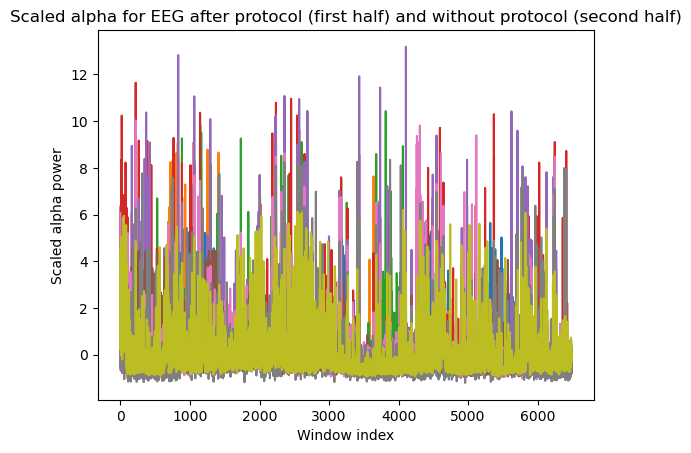

In [76]:
plt.plot(X_scaled)
plt.ylabel("Scaled alpha power")
plt.xlabel("Window index")
plt.title("Scaled alpha for EEG after protocol (first half) and without protocol (second half)")

In [77]:
X_scaled

array([[ 2.01011438,  6.05659182,  6.31342416, ...,  6.06735026,
         2.63001034,  3.45850535],
       [-0.55587808, -0.10281942, -0.23893076, ..., -0.42217512,
        -0.32734147,  0.19395058],
       [-0.55507053,  0.20234591, -0.31077723, ..., -0.67545205,
        -0.50162741,  4.53752566],
       ...,
       [-0.34238698, -0.28141686, -0.43739927, ...,  0.27906581,
         0.2906897 ,  0.62966358],
       [-0.14016769, -0.27322367, -0.46538045, ..., -0.64217064,
        -0.77121491, -0.30626878],
       [-0.16201652, -0.09423496, -0.30706081, ..., -0.05103534,
         0.39512888,  0.05030273]])

In [78]:
X_cnn = X_scaled.reshape(X_scaled.shape[0], len(eeg_columns), 1)


In [79]:
X_cnn.shape

(6486, 9, 1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)


In [81]:
# 7. Build CNN model
model = Sequential([
    Input(shape=(len(eeg_columns), 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),    # Input_shape=(channels, 1): num_channels time steps with 1 feature per step
    MaxPooling1D(pool_size=1),                                                   # MaxPooling layer: downsamples the output using a pool size of 1 (no real effect in this case)
    Flatten(),                                                                   # Flattens the output of the previous layer into a 1D vector for the dense layer
    Dense(16, activation='relu'),                                                # Fully connected (Dense) layer with 16 neurons and ReLU activation
    Dropout(0.3),                                                                # Dropout layer: randomly drops 30% of neurons during training to reduce overfitting
    Dense(1, activation='sigmoid')  # binary classification                      # Output layer: single neuron with sigmoid activation for binary classification (stress vs no stress)
])


In [82]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [83]:
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/20


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7848 - loss: 0.4842 - val_accuracy: 0.8584 - val_loss: 0.3394
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8585 - loss: 0.3220 - val_accuracy: 0.8690 - val_loss: 0.3039
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8822 - loss: 0.2889 - val_accuracy: 0.8844 - val_loss: 0.2796
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8944 - loss: 0.2701 - val_accuracy: 0.8940 - val_loss: 0.2614
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8951 - loss: 0.2589 - val_accuracy: 0.8940 - val_loss: 0.2542
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.2554 - val_accuracy: 0.8979 - val_loss: 0.2456
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9072 - loss: 0.2388 - val_accuracy: 0.9008 - val_loss: 0.2397
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9108 - loss: 0.2350 - val_accuracy: 0.9056 - val_

In [84]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {int(accuracy*100)}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.1986
Test Accuracy: 91%


This is looking pretty good! I wonder:
- What are the channels that influence the prediction the most. 
- How will it perform with a couple of fresh datasets that I collect this week?

## Evaluating the model

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.1986
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9199 - loss: 0.2016 - val_accuracy: 0.9200 - val_loss: 0.1993
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9227 - loss: 0.1907 - val_accuracy: 0.9143 - val_loss: 0.2014
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9188 - loss: 0.1989 - val_accuracy: 0.9171 - val_loss: 0.1986
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9212 - loss: 0.1949 - val_accuracy: 0.9220 - val_loss: 0.1965
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9222 - loss: 0.1940 - val_accuracy: 0.9191 - val_loss: 0.1971
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.1917 - val_accuracy: 0.9162 - val_loss: 0.2044
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9251 - loss: 0.1832 - val_accuracy: 0.9191 - val_loss: 0.2006
Epoch 8/20
130/130 ━━━━━━━━━━━━

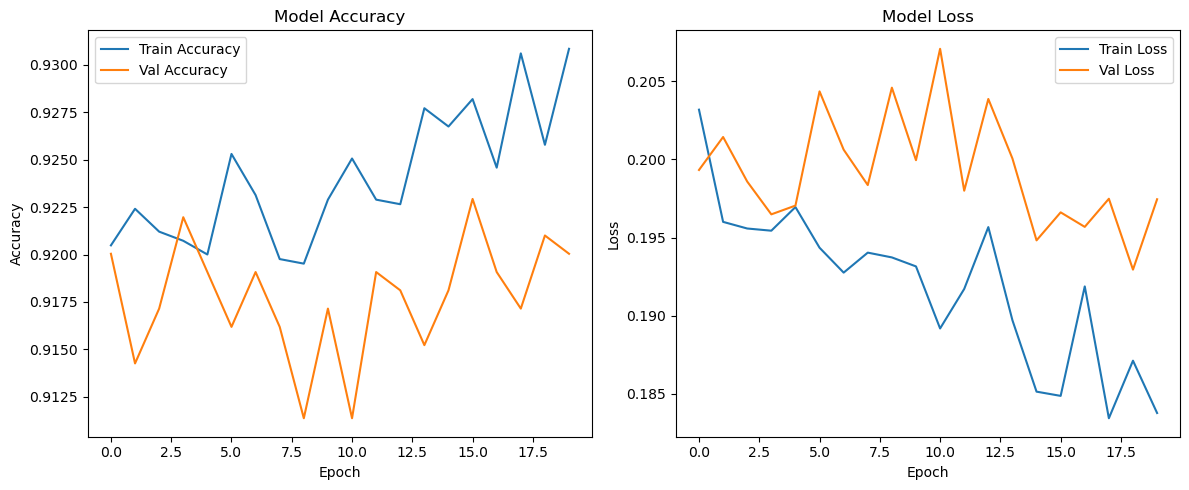

In [85]:
model.evaluate(X_test, y_test)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


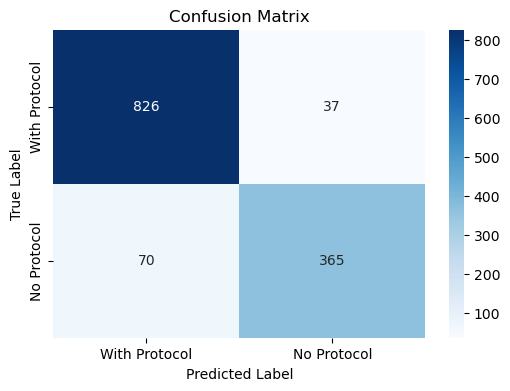

In [86]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['With Protocol', 'No Protocol'], yticklabels=['With Protocol', 'No Protocol'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()